In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

GAN에 대해서 알아보도록 하겠습니다.

### Load Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
import torchsummary
import torchvision.utils as vutils
from einops.layers.torch import Rearrange

In [ ]:
trainset = torchvision.datasets.MNIST(root = "", train = True, download = True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root = "", train = False, download = True, transform=torchvision.transforms.ToTensor())
print('number of training data : ', len(trainset))
print('number of test data : ', len(testset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw

number of training data :  60000
number of test data :  10000


In [ ]:
train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=32,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=32,
                                          shuffle=True)

### GAN

Generative Adversarial Nets, Ian Goodfellow et al., NeurIPS, 2014

#### 개요
- Generative model
- Generator와 Discriminator가 적대적으로 학습합니다.
- Generator는 기존 이미지와 유사한 이미지를 생성하려고 합니다.
- Discriminator는 주어진 이미지가 기존 분포(진짜)에 있는지, 혹은 생성된 이미지(가짜)인지 판별하려고 합니다.
- Generator와 Discriminator를 조합한 Loss를 이용하여 학습합니다.

#### 상세

- Generator와 Discriminator의 minimax 게임
- $min_G max_D V(D,G) = E_{x\sim p_{data}(x)}[log D(x)] + E_{x\sim p_z(x)}[log(1- D(G(z)))]$
- $D(x) = \frac{p_{data}(x)}{p_{data}(x) + p_z(x)}$

- Discriminator는 최대한 주어진 데이터를 잘 파악하려고 학습하게 됩니다.
- 그러나 generator는 discriminator가 제대로 파악하지 못하도록 이미지를 생성하게 학습합니다.
- 이렇게 적대적으로 학습을 하다보면 generator가 생성하는 이미지는 진짜 이미지의 분포와 같아지도록 학습이 되고, 결과적으로 $D(x)$는 1/2로 수렴하게 됩니다.

![image](https://www.researchgate.net/publication/349365459/figure/fig4/AS:992069090828289@1613539111608/Distributions-of-generator-and-discriminator-in-GAN-Goodfellow-et-al-2014.png)

수식이 매우 어렵게 느껴지실 분들을 위해 더 자세하게 설명해 드리겠습니다!

1. $D(x)$를 1로 만드는 경우 (판별자가 모든 것을 분류할 수 있는 경우)

$D(x)=1$인 상황은 $logD(x)$가 0이 되는 상황과 같습니다. $D(x)=1$이라는 의미는 판별자가 모든 것의 진위 여부를 정확하게 판별할 수 있음을 의미합니다. 이렇게 되면 동시에 $D(G(z))$가 0이 됩니다. Generator가 아무리 진짜와 같은 이미지를 생성하더라도 Discriminator가 100%의 확률로 전부 잡아낼 수 있기 때문이죠! 결과적으로 수식의 $logD(x)$와 $logD(G(z))$는 0이 되어 사라지게 됩니다.


2. $G(z)$를 1로 만드는 경우 (판별자가 모든 것을 분류하지 못하는 경우) 

$G(z)=1$인 상황은 Generator가 실제와 구분하지 못할 정도로 이미지를 비슷하게 만들어 Discriminator가 하나도 구분하지 못하는 상황과 같습니다. 이렇게 되면 수식의 $logD(x)$와 $log(1-D(G(z))$는 $log0$이 되어 무한에 수렴하게 됩니다. Loss가 무한대로 간다는 말은 최악의 상황이라는 거죠!

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        ## Encoder: 이미지를 latent 형태로 압축하는 모델
        ## Linear(1): (28x28) -> 128 / Linear(2): 128 ->  64 / Linear(3): 64 -> 1
        self.main = nn.Sequential(
            nn.Linear(??, ??),
            nn.ReLU(inplace=True),
            nn.Linear(??, ??),
            nn.ReLU(inplace=True),
            nn.Linear(??, ??),
            nn.Sigmoid()
        )

    def forward(self, x):      
        x = x.view(-1, 28 * 28)
        return self.main(x)

Discriminator 모델입니다. 하나의 hidden layer를 가진 MLP로 구성되어있으며, 이미지를 입력받아서 해당 이미지가 진짜인지 아닌지(0 혹은 1) 판단하게 됩니다.

In [ ]:
class Generator(nn.Module):
    def __init__(self,in_dim):
        super(Generator, self).__init__()

        ## Decoder: Latent로부터 이미지를 다시 재건축하는 모델
        ## Linear(1): in_dim -> 64 / Linear(2): 64 ->  128 / Linear(3): 128 -> 28*28
        self.main = nn.Sequential(
            nn.Linear(in_dim, ??),
            nn.ReLU(inplace=True), 
            nn.Linear(??, ??),   
            nn.ReLU(inplace=True),         
            nn.Linear(??, ??),
            nn.Sigmoid(),            
            Rearrange('b c (h w) -> b c h w', h=28, w=28)
        )

    def forward(self, x):              
        return self.main(x)

Generator 모델입니다. 역시 하나의 hidden layer를 가진 MLP로 구성되어 있으며, 특정 dimension을 가진 latent vector로부터 28x28의 이미지를 생성하는 모델입니다.

처음에는 noise와 같이 의미없는 이미지를 만들어내지만, 점점 학습하면서 본래의 이미지와 유사한 이미지를 생성하게 됩니다.

In [ ]:
nz = 10
gpu = torch.device("cuda")
netG = Generator(nz).to(gpu)
netD = Discriminator().to(gpu)
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, 1, nz, device=gpu)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters())
optimizerG = torch.optim.Adam(netG.parameters())

이제 학습을 진행해보도록 하겠습니다.


- Discriminator: 진짜 이미지를 받았을때는 real_label(1), 가짜 이미지를 받았을 때는 fake_label(0)이 나오도록 학습합니다.
- Generator: Discriminator에게 fake image를 주고 real_label이 나오도록 학습을 합니다.

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 20
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for _, (data,_) in enumerate(tqdm(train_loader)):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(gpu)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), ??, dtype=torch.float, device=gpu) ## ?? 에 real_label 또는 fake_label 넣으시오.
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 1,nz, device=gpu)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(??)  ## ?? 에 real_label 또는 fake_label 넣으시오.
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(??)   ## ?? 에 real_label 또는 fake_label 넣으시오.
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise    
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    # Output training stats        
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
          % (epoch+1, num_epochs,errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...


100%|██████████| 1875/1875 [00:16<00:00, 113.22it/s]


[1/20]	Loss_D: 0.0069	Loss_G: 7.1203	D(x): 1.0000	D(G(z)): 0.0068 / 0.0016


100%|██████████| 1875/1875 [00:16<00:00, 115.55it/s]


[2/20]	Loss_D: 0.0479	Loss_G: 7.1719	D(x): 0.9999	D(G(z)): 0.0428 / 0.0033


100%|██████████| 1875/1875 [00:16<00:00, 115.74it/s]


[3/20]	Loss_D: 0.0378	Loss_G: 5.9551	D(x): 0.9937	D(G(z)): 0.0289 / 0.0150


100%|██████████| 1875/1875 [00:16<00:00, 113.50it/s]


[4/20]	Loss_D: 0.1181	Loss_G: 5.9585	D(x): 0.9506	D(G(z)): 0.0247 / 0.0263


100%|██████████| 1875/1875 [00:16<00:00, 113.10it/s]


[5/20]	Loss_D: 0.2790	Loss_G: 4.9139	D(x): 0.9362	D(G(z)): 0.0323 / 0.0145


100%|██████████| 1875/1875 [00:16<00:00, 115.12it/s]


[6/20]	Loss_D: 0.2835	Loss_G: 2.7003	D(x): 0.9939	D(G(z)): 0.2047 / 0.1423


100%|██████████| 1875/1875 [00:16<00:00, 114.00it/s]


[7/20]	Loss_D: 0.1779	Loss_G: 4.1877	D(x): 0.9240	D(G(z)): 0.0279 / 0.0327


100%|██████████| 1875/1875 [00:16<00:00, 113.37it/s]


[8/20]	Loss_D: 0.6302	Loss_G: 3.3407	D(x): 0.7704	D(G(z)): 0.0708 / 0.0683


100%|██████████| 1875/1875 [00:16<00:00, 114.00it/s]


[9/20]	Loss_D: 0.5409	Loss_G: 2.7915	D(x): 0.8754	D(G(z)): 0.1695 / 0.1323


100%|██████████| 1875/1875 [00:16<00:00, 113.59it/s]


[10/20]	Loss_D: 0.3391	Loss_G: 2.5320	D(x): 0.8762	D(G(z)): 0.1365 / 0.1259


100%|██████████| 1875/1875 [00:16<00:00, 114.19it/s]


[11/20]	Loss_D: 0.3249	Loss_G: 2.3540	D(x): 0.9300	D(G(z)): 0.1805 / 0.1667


 16%|█▌        | 291/1875 [00:02<00:13, 116.53it/s]

학습이 완료되었습니다. loss를 확인해보면 처음에는 D_loss가 작은 것으로 보아 discriminator가 진짜와 가짜를 잘 구별하는 것을 알 수 있습니다.

그러나 학습이 진행될수록 G_loss가 감소하면서 진짜 이미지와 유사한 이미지를 생성해내고, 이를 discriminator가 잘 구분을 못하는 것을 볼 수가 있습니다.

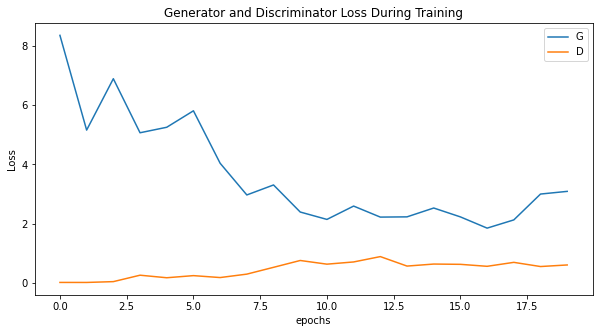

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

그렇다면, 생성된 이미지를 확인해 볼까요?

처음에는 아무런 의미가 없는 이미지를 생성하지만, 학습이 진행될수록 점점 MNIST 손글씨 데이터와 유사해지는 것을 알 수 있습니다.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

마지막으로 진짜 데이터와 가짜 데이터를 비교해보도록 하겠습니다.

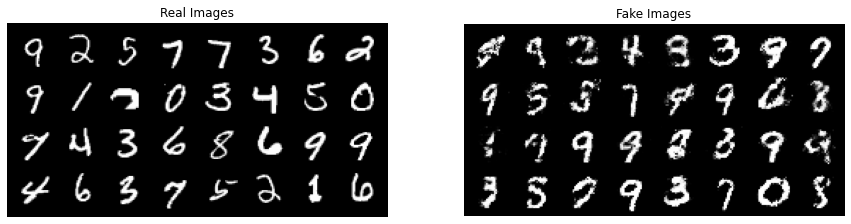

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

---

### 마치며

이번 시간을 통해 드디어 경도팀이 다루고 싶어 했던 생성모델인 GAN에 대해서 같이 알아보는 시간을 가져보았습니다.

GAN은 VAE에서 사용했던 Bayesian 이론들이 필요 없이 딥러닝 요소만으로 학습이 이루어진다는 장점이 있습니다.

그러나, 생성된 이미지의 분포가 명시적으로 존재하지 않고, generator와 discriminator의 균형을 맞추는게 중요합니다.

다음 시간에는 Convolutional layer만으로 이루어진 DCGAN에 대한 설명과, 실습 코드를 포스팅하도록 하겠습니다.

감사합니다!

---

### Reference

- Generative Adversarial Nets: https://arxiv.org/abs/1406.2661
- NIPS 2016 Tutorial: Generative Adversarial Networks: https://arxiv.org/abs/1701.00160
- Pytorch DCGAN tutorial: https://tutorials.pytorch.kr/beginner/dcgan_faces_tutorial.html